# crossfit open 2018 supervised learning
In the previous notebook `open_182a_bayesian_regression`, we used the athlete profile benchmarks to perform regression on workout 18.2a. This notebook will focus on regressing the entire Open. First, we'll use the benchmarks to regress each open workout and analyze the results. Afterwards, we'll attempt to find redundancies in the Open. To predict some Open workout *x*, we'll use the other Open workouts *along with* the benchmarks to attempto better regress Open scores.

## imports
Here we'll import all the modules we'll make use of thoughout this notebook.

In [1]:
#working with ids to implement custom train/test splitting
import numpy as np
#working locally with data (dataframes)
import pandas as pd
#data scaling, learning agents
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
#prediction scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
#plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

#custom modules
import sys
sys.path.insert(0, "../custom_modules/")
#seaborn/matplotlib styling
import seaborn_styler as sbs

## reading in the data
The data has previously been filtered/collected from a database in another learning notebook and written to CSV. We'll grab that data here.

In [2]:
raw_df = pd.read_csv("../sample_data/sample_pure_division_18.csv").drop(["Unnamed: 0"], axis=1)
raw_df.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,328,651,207,1373,637,77,77,225,335,265,210,415,32,226,174,496,1287,64,1325
1,93,309,480,235,1548,642,94,72,205,305,235,185,355,45,220,154,493,1500,62,1239
2,1636,402,316,260,1148,577,123,70,200,400,285,215,485,67,138,108,429,1056,58,1219


## grabbing columns of interest
This notebook will work on performing machine learning for the open workouts. These learning tasks will occur in 2 forms: with the other remaining open workouts as features, and without (only benchmarks). We'll start by extracting these Open workouts.

In [3]:
open_keys = list(raw_df.columns[1:7])
open_keys

['leaderboard_18_1_reps',
 'leaderboard_18_2_time_secs',
 'leaderboard_18_2a_weight_lbs',
 'leaderboard_18_3_time_secs',
 'leaderboard_18_4_time_secs',
 'leaderboard_18_5_reps']

## scaling the data
We'll scale this data using scikit-learn's `StandardScaler`, which scales each feature independently to unit variance.

In [4]:
x = [1,2,3]
x.remove(2)
x

[1, 3]

In [5]:
scaled_data = StandardScaler().fit_transform(raw_df.drop(["id"], axis=1))
df = pd.concat(
    [
        raw_df[["id"]],
        #all columns but id in the columns=... statement
        pd.DataFrame(scaled_data, columns=list(raw_df.columns)[1:])
    ],
    axis=1
)
df.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,0.158430,2.065809,-1.132659,0.328936,0.414922,-0.546937,1.103061,1.694207,-0.477036,0.182866,0.285815,-0.454332,-0.581332,-0.004048,0.066970,-0.473635,-0.387131,-0.333732,0.105375
1,93,-0.181246,0.266425,-0.359136,0.941889,0.453402,-0.061351,0.336881,0.736628,-0.979968,-0.599759,-0.438017,-1.409255,0.326252,-0.077476,-0.215067,-0.506319,0.265119,-0.495560,-0.434557
2,1636,1.481380,-1.459299,0.331510,-0.459145,-0.046834,0.767001,0.030409,0.497233,0.612652,0.704616,0.430581,0.659746,1.862164,-1.080997,-0.863752,-1.203567,-1.094500,-0.819216,-0.560122


## splitting the data based on features
So we know there will be 6 different dependents (18.1, 18.2, 18.2a, 18.3, 18.4, 18.5), but each of these will have 2 feature sets, 1 for each learning task (benchmarks, benchmarks and other Open workouts). We'll do this separation of data iteratively below.

In [6]:
datasets = {
    #18.1
    #"1_limited": [features_1_limited_df, targets_1_limited_df],
    #"1_full": [features_1_limited_df, targets_1_limited_df],
    #"2_limited": ...
}
#iterate over each dependent
for i in range(len(open_keys)):
    #limited dataset
    datasets["{}_limited".format(i)] = [
        #features (only benchmarks)
        df.drop(open_keys, axis=1),
        #targets
        df[["id", open_keys[i]]]
    ]
    #full dataset
    datasets["{}_full".format(i)] = [
        #features (benchmarks and other open workouts)
        df.drop(open_keys[i], axis=1),
        #targets
        df[["id", open_keys[i]]]
    ]

In [7]:
#only benchmark features
datasets["0_limited"][0].head(3)

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,1.103061,1.694207,-0.477036,0.182866,0.285815,-0.454332,-0.581332,-0.004048,0.066970,-0.473635,-0.387131,-0.333732,0.105375
1,93,0.336881,0.736628,-0.979968,-0.599759,-0.438017,-1.409255,0.326252,-0.077476,-0.215067,-0.506319,0.265119,-0.495560,-0.434557
2,1636,0.030409,0.497233,0.612652,0.704616,0.430581,0.659746,1.862164,-1.080997,-0.863752,-1.203567,-1.094500,-0.819216,-0.560122


In [8]:
#only benchmark targets
datasets["0_limited"][1].head(3)

,id,leaderboard_18_1_reps
0,86,0.158430
1,93,-0.181246
2,1636,1.481380


In [9]:
#benchmarks and other open workouts features
datasets["0_full"][0].head(3)

,id,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,2.065809,-1.132659,0.328936,0.414922,-0.546937,1.103061,1.694207,-0.477036,0.182866,0.285815,-0.454332,-0.581332,-0.004048,0.066970,-0.473635,-0.387131,-0.333732,0.105375
1,93,0.266425,-0.359136,0.941889,0.453402,-0.061351,0.336881,0.736628,-0.979968,-0.599759,-0.438017,-1.409255,0.326252,-0.077476,-0.215067,-0.506319,0.265119,-0.495560,-0.434557
2,1636,-1.459299,0.331510,-0.459145,-0.046834,0.767001,0.030409,0.497233,0.612652,0.704616,0.430581,0.659746,1.862164,-1.080997,-0.863752,-1.203567,-1.094500,-0.819216,-0.560122


In [10]:
#benchmarks and other open workouts targets
datasets["0_full"][1].head(3)

,id,leaderboard_18_1_reps
0,86,0.158430
1,93,-0.181246
2,1636,1.481380


## splitting ids into training and testing
We'll split the data into training/testing sets on a per-id basis.

In [11]:
training_size = .8
ids = df["id"].values
train_ids = np.random.choice(ids, size=int(len(ids) * training_size), replace=False)
train_ids

array([  11586,    2649,    9106,  665812,    4620,  413402,  461814,
         79664,   60346,    4645,    5238,  302852,   28812,  114032,
          4158,  277609,  396150,    8496,    6334,  678723,  325664,
         23447,    2220,    2808,  775067,  671575,  161133,    7534,
        348134,   36588,  535071,  114260,  113902,   31631,  803424,
         78241,   38781,  143549,    5003,  292529,    4842,    3805,
         42024,   17258,   21003,   10605,   23253,    2573,   31188,
         84783,   71831,   44131,   16699,   26756,   51992,  503903,
          9405,  918639,  282422,  658554,  971888,  201020,  558738,
        682487,  518554,   24366,   98711,  906114,   77459,   34708,
        259682,   33457,  256874,  254219,  241391,   11826,   43310,
         44348,   33216,  237934,   35874,   27065,  161269,   88946,
         22538,   91497,   35012,  529744,   16869,  197022,   35766,
          2073,   50347,  334064,  136918,    1662,  110883,   18276,
        143814,  412

In [12]:
#get ids that aren't in train_ids
test_ids = np.setdiff1d(ids, train_ids)
test_ids

array([     86,    1665,    1974,    2896,    3000,    3354,    3855,
          4407,    4499,    5405,    5674,    5961,    6279,    6740,
          8851,    8913,    9193,    9217,    9906,   10926,   11126,
         11224,   11549,   12329,   12908,   13573,   13909,   14924,
         15237,   16495,   16507,   19900,   20349,   22661,   22885,
         24599,   24613,   26515,   28501,   30310,   36494,   36803,
         40470,   42521,   47657,   47731,   48418,   54233,   60413,
         60547,   60561,   64501,   66862,   71780,   71965,   82939,
         92912,   98737,  102256,  105216,  105934,  106491,  110659,
        112627,  124169,  132810,  138612,  149404,  153742,  168610,
        170731,  179308,  191004,  214125,  215118,  239783,  239786,
        256514,  259771,  266179,  284760,  317927,  337638,  372305,
        379392,  386135,  391024,  428068,  428642,  429208,  467774,
        468457,  474531,  513146,  519766,  546782,  547085,  549326,
        622422,  706

## fitting learners to each dataset
For each dataset we'll fit 3 different types of learners: [bayesian regressors](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge), [neural networks](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), and [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). We'll iteratively fit and store a learner of each type for each of the 12 datasets.

### model parameters
We'll not tune these models individually for each dataset. There is a great amount of shared data between them, and although there may be some small gains for each learning task if tuned individually, this tuning will not be performed. The parameters used for each model will be set below.

In [13]:
#default parameters
random_state = 0
#bayes

#neural net
max_iter = 500
#random forest
max_depth = 5
min_samples_leaf = 3

In [14]:
datasets["{}_limited".format(0)][1].head(3)

,id,leaderboard_18_1_reps
0,86,0.158430
1,93,-0.181246
2,1636,1.481380


### fitting learners
The learners will be fit to each dataset and assigned to the `mlmap` below.

In [15]:
mlmap={}
#iterate over each dependent (6 total)
for i in range(len(open_keys)):
    #get keys
    data_keys = list(map(lambda x: x.format(i), ["{}_limited", "{}_full"]))
    
    #for each dataset (2 total)
    for j in range(len(data_keys)):
        #make kvp entry
        mlmap[data_keys[j]] = {
            #train: training features/targets,
            #test: testing features/targets,
            #learners: learners fit to training set, meant to be tested on testing set
        }
        
        #get dataset
        tmp_dfs = datasets[data_keys[j]]
        
        #the only difference between the next 2 list assignments is
        #".isin(train_ids)" and ".isin(test_ids)"
        #- likely candidate for iteration
        #training
        mlmap[data_keys[j]]["train"] = [
            #features
            tmp_dfs[0][tmp_dfs[0]["id"].isin(train_ids)],
            #targets
            tmp_dfs[1][tmp_dfs[1]["id"].isin(train_ids)]
        ]
        #testing
        mlmap[data_keys[j]]["test"] = [
            #features
            tmp_dfs[0][tmp_dfs[0]["id"].isin(test_ids)],
            #targets
            tmp_dfs[1][tmp_dfs[1]["id"].isin(test_ids)]
        ]
        
        #fit 3 learners to training data
        training_set = mlmap[data_keys[j]]["train"]
        tmp_x = training_set[0].drop(["id"], axis=1)
        tmp_y = np.ravel(training_set[1].drop(["id"], axis=1))
        mlmap[data_keys[j]]["learners"] = [
            #bayes
            BayesianRidge(
                compute_score=True,
            ).fit(tmp_x, tmp_y),
            
            #neural network
            MLPRegressor(
                #the below -1 factors are to remove the ID column counts
                hidden_layer_sizes=(
                    #input layer (this is A LOT simpler than it looks)
                    len(training_set[0].columns) - 1,
                    #hidden layer (https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)
                    #mean(input layer neurons and output layer neurons)
                    #= (len(training_set[1].columns) - 1 + len(training_set[1].columns) - 1) * .5
                    #= (len(training_set[1].columns) - 1 + 2 - 1) * .5
                    #= len(training_set[1].columns) * .5
                    int(
                        np.ceil(
                            len(training_set[1].columns) * .5
                        )
                    ),
                    #output layer
                    1
                ),
                #maximum iterations to perform before stopping training
                max_iter=max_iter,
                #random state
                random_state=random_state
            ).fit(tmp_x, tmp_y),
            
            #random forest
            RandomForestRegressor(
                #max depth
                max_depth=max_depth,
                #minimum leaf samples required to not prune
                min_samples_leaf = min_samples_leaf,
                #random state
                random_state=random_state
            ).fit(tmp_x, tmp_y)
        ]

## plotting predictions vs. ground truth
Before scoring the learners, we can see visually how each performed vs. the ground truth (how athletes actually performed in the workouts).

First, we'll get the dictionary keys for each dataset.

In [16]:
#data keys
data_keys = []
for i in range(len(open_keys)):
    data_keys += list(map(lambda x: x.format(i), ["{}_limited", "{}_full"]))
", ".join(data_keys)

'0_limited, 0_full, 1_limited, 1_full, 2_limited, 2_full, 3_limited, 3_full, 4_limited, 4_full, 5_limited, 5_full'

### plotting
Below we'll actually plot the data using Matplotlib. However, the seaborn styling used in this project *may* require seaborn, so both seaborn and the styling module have been imported above. The styling should be run before plotting to set the graph style, and it only needs to be run once *or* whenever the style is changed and it's desired to revert back to the default styling.

In [17]:
#double figure width
#the notebook will limit this size...so it'll probably be less than double
if sbs.figure_size == [8, 6]:
    sbs.figure_size = [sbs.figure_size[0] * 2, sbs.figure_size[1]]
sbs.stylize()

In [18]:
color_map = {
    "real": "#00ccff",
    "bayesian": "#ffcc00",
    "neuralnet": "#ff0066",
    "randomforest": "#99ff33"
}

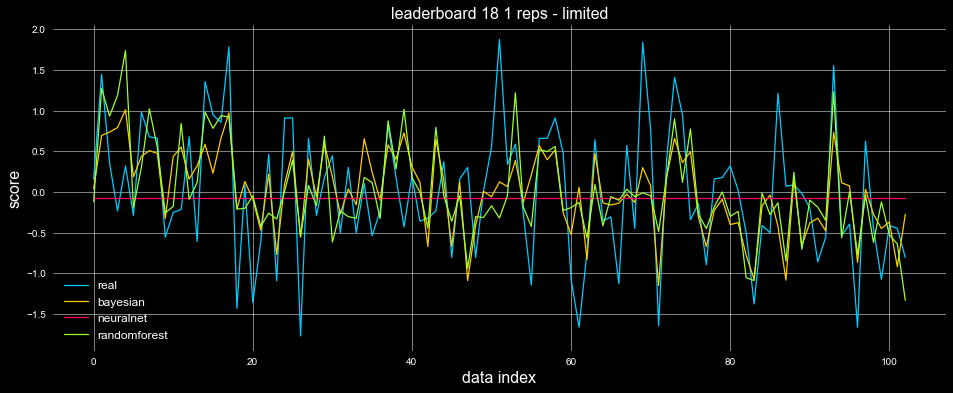

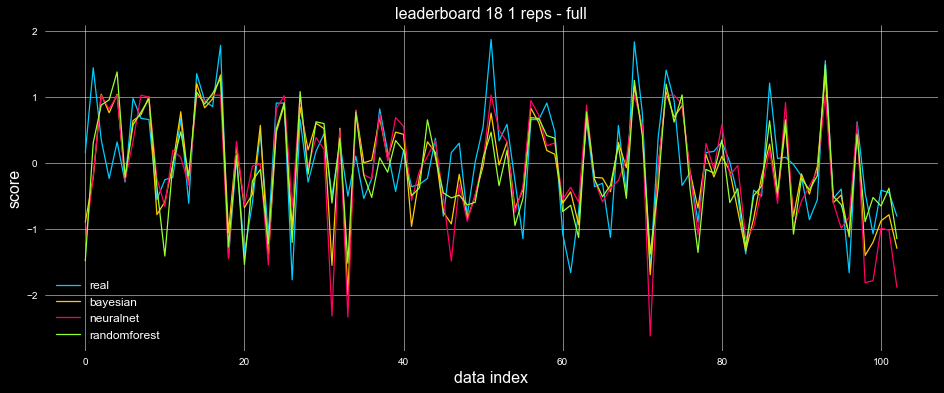

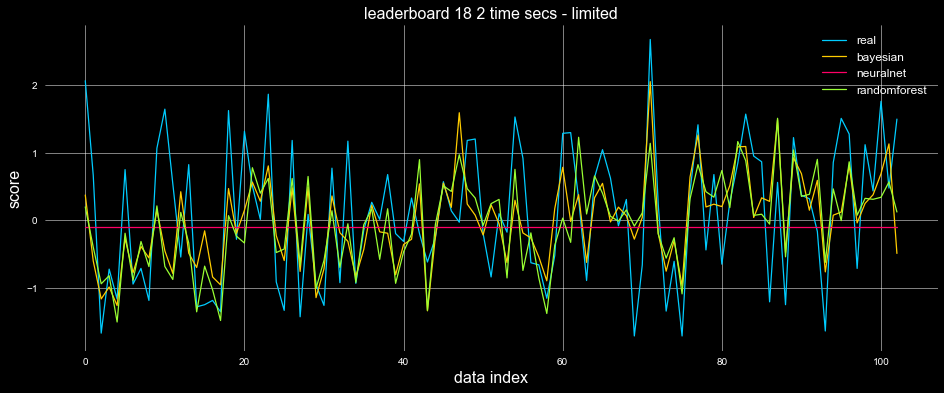

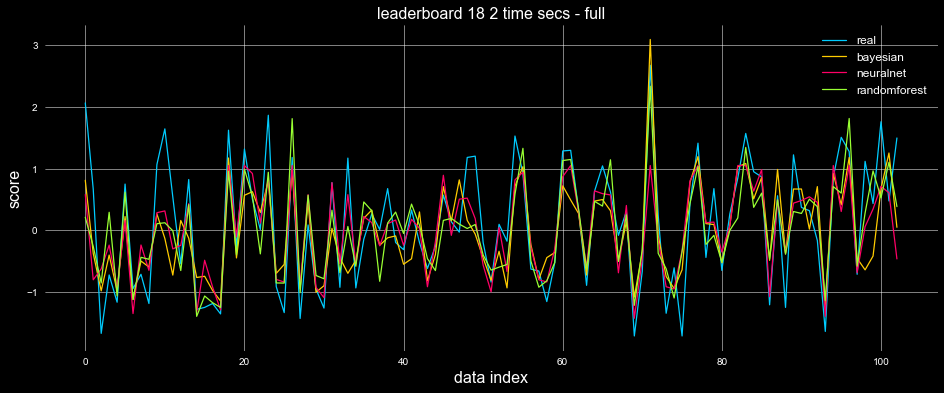

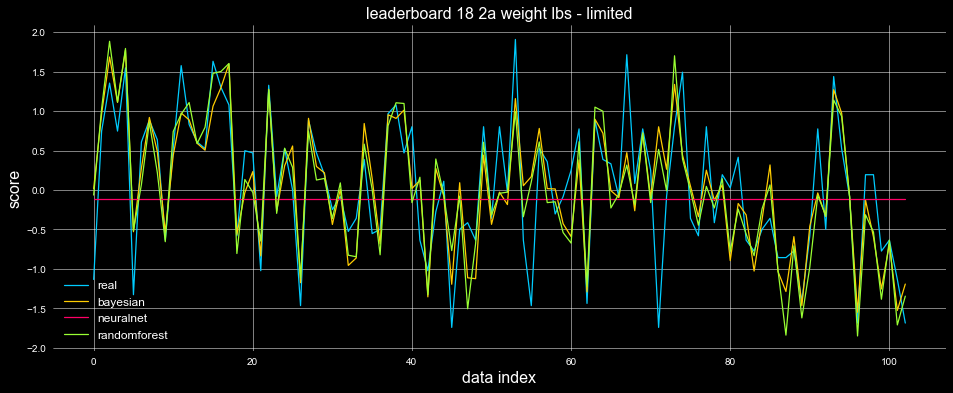

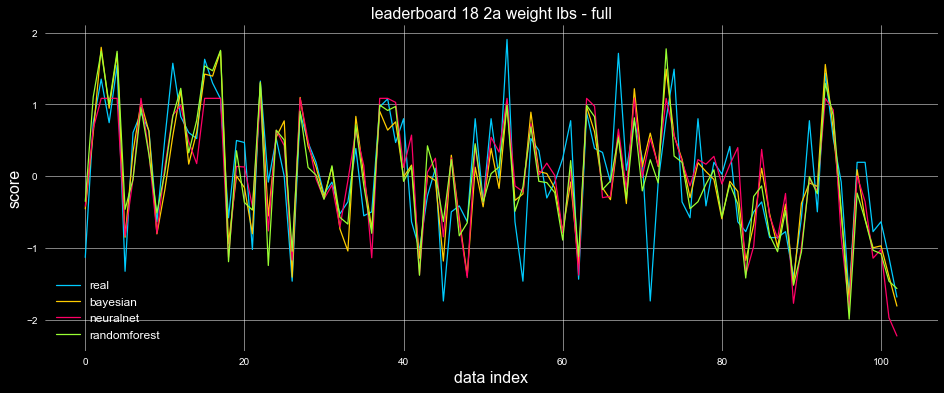

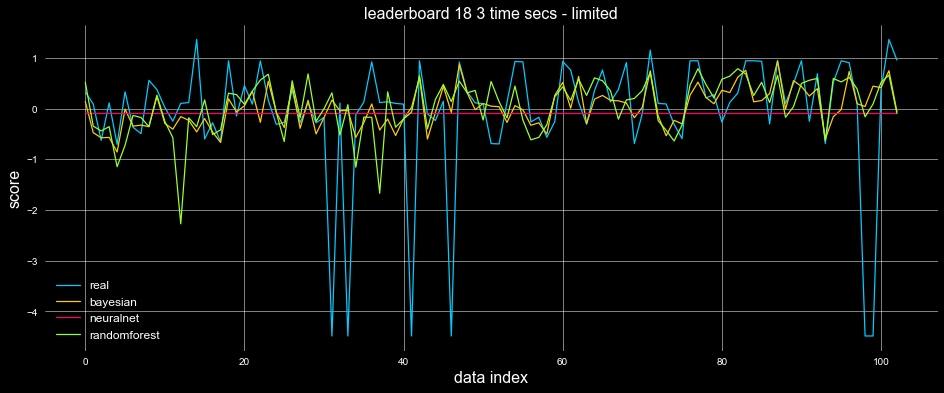

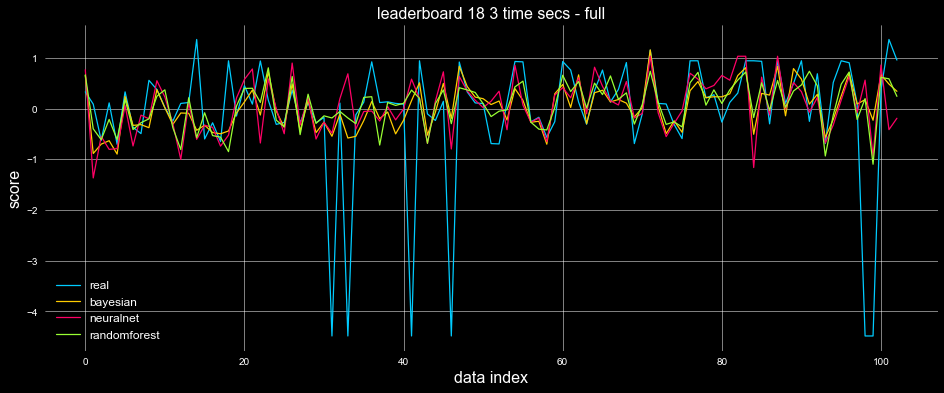

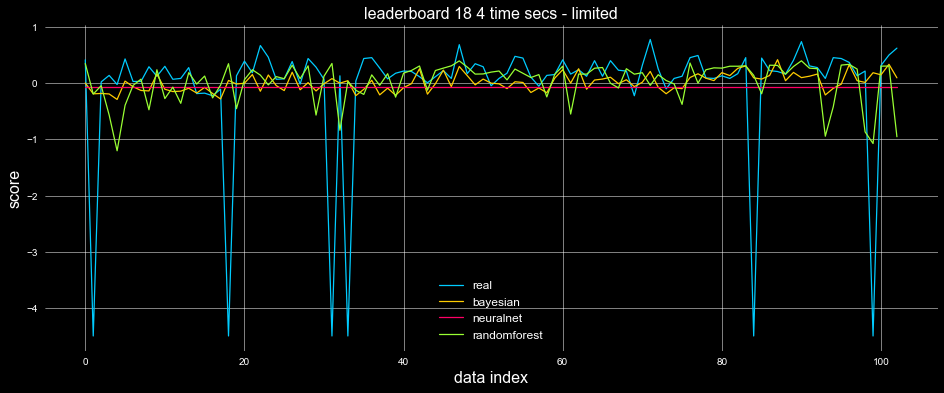

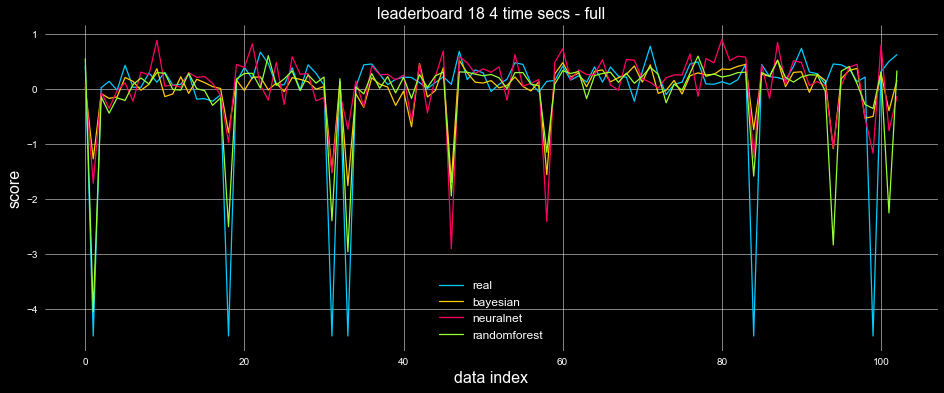

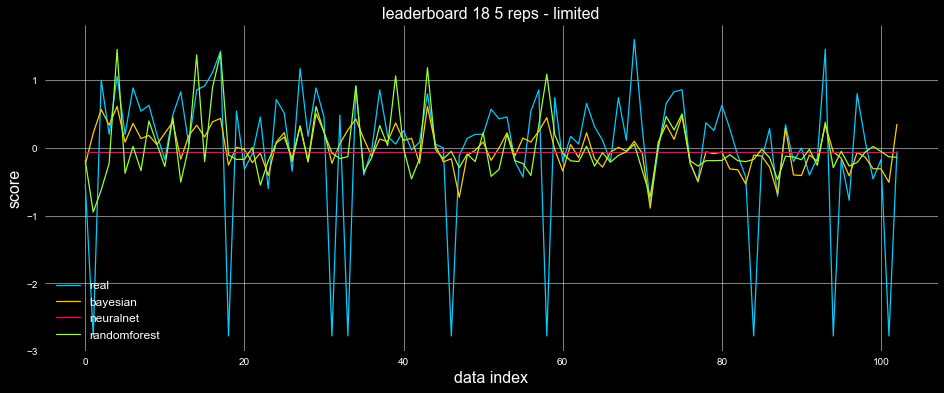

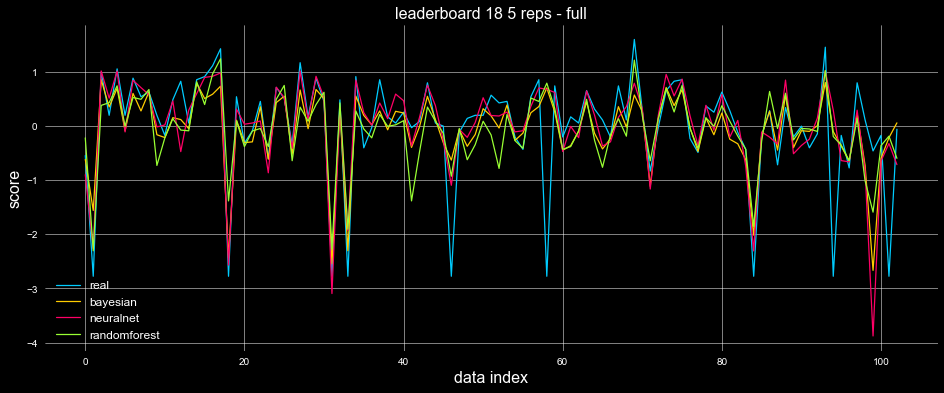

In [19]:
#will be used to store predictions and ground truths for each test dataset
pred_map = {}
#for each dataset
for dk in data_keys:
    #get testing targets
    targets = mlmap[dk]["test"][1]
    #reformat
    #https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    targets = targets.assign(num=pd.Series(np.arange(len(targets))).values).drop(["id"], axis=1)
    targets = targets[["num", targets.columns[0]]]
    
    #plot ground truth
    plt.plot(
        targets.columns[0],
        targets.columns[1],
        data=targets,
        label="real",
        color=color_map["real"]
    )
    #plot predictions
    learners = mlmap[dk]["learners"]
    #learner predictions dataframe
    preds = pd.DataFrame(targets[["num"]])
    #bayesian
    preds = preds.assign(bayesian=learners[0].predict(mlmap[dk]["test"][0].drop(["id"], axis=1)))
    #neural net
    preds = preds.assign(neuralnet=learners[1].predict(mlmap[dk]["test"][0].drop(["id"], axis=1)))
    #random forest
    preds = preds.assign(randomforest=learners[2].predict(mlmap[dk]["test"][0].drop(["id"], axis=1)))
    #store all predictions and ground truth in map
    pred_map[dk] = pd.concat([preds, targets[targets.columns[-1]]], axis=1)
    
    #creating visuals
    for c in list(preds.columns[1:]):
        plt.plot(
            preds.columns[0],
            c,
            data=preds,
            label=c,
            color=color_map[c]
        )
    
    plt.legend(loc="best")
    plt.xlabel("data index")
    plt.ylabel("score")
    plt.title("{}".format(targets.columns[-1].replace("_", " ") + " - " + dk.split("_")[-1]))
    plt.show()

In [20]:
pd.concat([preds, targets[targets.columns[-1]]], axis=1).head(3)

,num,bayesian,neuralnet,randomforest,leaderboard_18_5_reps
0,0,-0.618843,-0.901216,-0.221161,-0.546937
4,1,-1.560176,-2.262927,-2.305044,-2.774920
7,2,0.852907,1.014406,0.378886,0.995512


## scoring the regressors
Seeing as how each regressor has now produced predictions for the test set, we can score them basedon their MSE and R<sup>2</sup> values.

In [21]:
decimal_precision = 3
for dk in sorted(pred_map.keys()):
    #output dataset
    print(dk)
    #score each learner
    for c in pred_map[dk].columns[1:4]:
        print("  {}\tMSE: {}\tR2: {}".format(
            c,
            np.round(
                mean_squared_error(
                    pred_map[dk][pred_map[dk].columns[-1]],
                    pred_map[dk][c]
                ),
                decimal_precision
            ),
            np.round(
                r2_score(
                    pred_map[dk][pred_map[dk].columns[-1]],
                    pred_map[dk][c]
                ),
                decimal_precision
            )
        ))

0_full
  bayesian	MSE: 0.284	R2: 0.557
  neuralnet	MSE: 0.424	R2: 0.339
  randomforest	MSE: 0.287	R2: 0.553
0_limited
  bayesian	MSE: 0.426	R2: 0.335
  neuralnet	MSE: 0.646	R2: -0.007
  randomforest	MSE: 0.497	R2: 0.224
1_full
  bayesian	MSE: 0.424	R2: 0.582
  neuralnet	MSE: 0.338	R2: 0.666
  randomforest	MSE: 0.348	R2: 0.657
1_limited
  bayesian	MSE: 0.621	R2: 0.387
  neuralnet	MSE: 1.058	R2: -0.043
  randomforest	MSE: 0.688	R2: 0.322
2_full
  bayesian	MSE: 0.274	R2: 0.629
  neuralnet	MSE: 0.299	R2: 0.595
  randomforest	MSE: 0.304	R2: 0.589
2_limited
  bayesian	MSE: 0.288	R2: 0.611
  neuralnet	MSE: 0.765	R2: -0.035
  randomforest	MSE: 0.309	R2: 0.582
3_full
  bayesian	MSE: 1.302	R2: 0.117
  neuralnet	MSE: 1.522	R2: -0.033
  randomforest	MSE: 1.296	R2: 0.12
3_limited
  bayesian	MSE: 1.446	R2: 0.019
  neuralnet	MSE: 1.474	R2: -0.001
  randomforest	MSE: 1.547	R2: -0.05
4_full
  bayesian	MSE: 0.843	R2: 0.331
  neuralnet	MSE: 0.935	R2: 0.258
  randomforest	MSE: 0.629	R2: 0.501
4_limited
  